## Import packages you need and data

In [3]:
## import all the packages you need 
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
warnings.filterwarnings('ignore')

## Import data

In [4]:
# Enter database connection parameters
# Could also store and read these as environment variables,
# but best practice is to never include credentials directly
# in version control
hostname = input("Enter server hostname: ")
username = input("Enter username: ")
password = getpass("Enter password: ")
database_name = input("Enter database name: ")

Enter server hostname:  spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com
Enter username:  introml568
Enter password:  ········
Enter database name:  urineculture


In [5]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [6]:
# Get dataset
df_short = pd.read_sql("select * from public.results", db_connection);

In [7]:
df_short.head()

,id,patid,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,skin_preps,smoking_deterrents,thyroid_preps,unclassified_drug_products,vitamins,dispo,UTI_diag,split,abxUTI,alt_diag
0,1,1,1,few,negative,negative,clear,yellow,small,negative,...,0,0,0,0,0,Admit,1,training,1,0
1,2,1,0,many,negative,small,clear,yellow,None,negative,...,0,0,0,0,1,Admit,1,training,1,0
2,3,2,1,few,negative,negative,clear,yellow,small,negative,...,0,0,1,1,0,Discharge,0,training,0,0
3,4,3,1,many,negative,negative,not_clear,yellow,None,negative,...,0,0,0,0,1,Admit,1,training,1,0
4,5,4,0,moderate,small,negative,clear,orange,None,negative,...,0,0,0,0,0,AMA,0,training,0,0


In [8]:
# Define the URL to the dataset
data_url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0194085.s001"

# Use pandas to read the dataset into a DataFrame
df = pd.read_csv(data_url)

## Data Dictionary Review

In [9]:
# Display the first few rows of the DataFrame
print(df.head())

# Get basic information about the DataFrame
print(df.info())

# Get summary statistics of numeric columns
print(df.describe())

print(df.columns)

   ID  PATID UCX_abnormal ua_bacteria   ua_bili  ua_blood ua_clarity ua_color  \
0   1      1          yes         few  negative  negative      clear   yellow   
1   2      1           no        many  negative     small      clear   yellow   
2   3      2          yes         few  negative  negative      clear   yellow   
3   4      3          yes        many  negative  negative  not_clear   yellow   
4   5      4           no    moderate     small  negative      clear   orange   

         ua_epi ua_glucose  ... SKIN_PREPS SMOKING_DETERRENTS THYROID_PREPS  \
0         small   negative  ...         No                 No            No   
1  not_reported   negative  ...         No                 No            No   
2         small   negative  ...         No                 No           Yes   
3  not_reported   negative  ...         No                 No            No   
4  not_reported   negative  ...         No                 No            No   

  UNCLASSIFIED_DRUG_PRODUCTS VITAMINS 

## Exploratory Data Analysis (EDA)

## Summary Statistics for Continuous Variables:

In [10]:
# Selecting continuous variables
continuous_vars = df.select_dtypes(include=['float64', 'int64'])

# Summary statistics
summary_stats_continuous = continuous_vars.describe()

# Display summary statistics
print(summary_stats_continuous)

                 ID         PATID  ua_spec_grav           age      alt_diag
count  80387.000000  80387.000000  80387.000000  80387.000000  80387.000000
mean   40194.000000  27160.079602      1.019084     53.801436      0.056029
std    23205.872382  16045.123111      0.018803     22.250829      0.229979
min        1.000000      1.000000      0.018000     18.000000      0.000000
25%    20097.500000  13267.500000      1.013000     34.000000      0.000000
50%    40194.000000  26693.000000      1.018000     53.000000      0.000000
75%    60290.500000  40826.500000      1.025000     72.000000      0.000000
max    80387.000000  55365.000000      5.500000    109.000000      1.000000


In [11]:
continuous_vars.describe()

,ID,PATID,ua_spec_grav,age,alt_diag
count,80387.000000,80387.000000,80387.000000,80387.000000,80387.000000
mean,40194.000000,27160.079602,1.019084,53.801436,0.056029
std,23205.872382,16045.123111,0.018803,22.250829,0.229979
min,1.000000,1.000000,0.018000,18.000000,0.000000
25%,20097.500000,13267.500000,1.013000,34.000000,0.000000
50%,40194.000000,26693.000000,1.018000,53.000000,0.000000
75%,60290.500000,40826.500000,1.025000,72.000000,0.000000
max,80387.000000,55365.000000,5.500000,109.000000,1.000000


## Summary Statistics for Categorical Variables:

In [12]:
# Selecting categorical variables
categorical_vars = df.select_dtypes(include=['object'])

# Summary statistics
summary_stats_categorical = categorical_vars.describe()

# Display summary statistics
print(summary_stats_categorical)

       UCX_abnormal   ua_bacteria   ua_bili  ua_blood ua_clarity ua_color  \
count         80387         80387     80387     80387      80387    80387   
unique            2             6         6         6          3        7   
top              no  not_reported  negative  negative      clear   yellow   
freq          62103         30225     71731     44585      40787    70841   

       ua_epi ua_glucose ua_ketones   ua_leuk  ... SEDATIVE_HYPNOTICS  \
count   80387      80387      80387     80387  ...              80387   
unique      6          6          7         6  ...                  2   
top     small   negative   negative  negative  ...                 No   
freq    35539      72645      66019     44406  ...              74827   

       SKIN_PREPS SMOKING_DETERRENTS THYROID_PREPS UNCLASSIFIED_DRUG_PRODUCTS  \
count       80387              80387         80387                      80387   
unique          2                  2             2                          2   
top  

In [13]:
categorical_vars.describe()

,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,ua_ketones,ua_leuk,...,SEDATIVE_HYPNOTICS,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS,dispo,UTI_diag,split,abxUTI
count,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387,...,80387,80387,80387,80387,80387,80387,80387,80387,80387,80387
unique,2,6,6,6,3,7,6,6,7,6,...,2,2,2,2,2,2,11,2,2,2
top,no,not_reported,negative,negative,clear,yellow,small,negative,negative,negative,...,No,No,No,No,No,No,Discharge,No,training,yes
freq,62103,30225,71731,44585,40787,70841,35539,72645,66019,44406,...,74827,71424,78947,70526,64674,54556,42744,63221,64310,45151


## Charts for Demographic Variables 

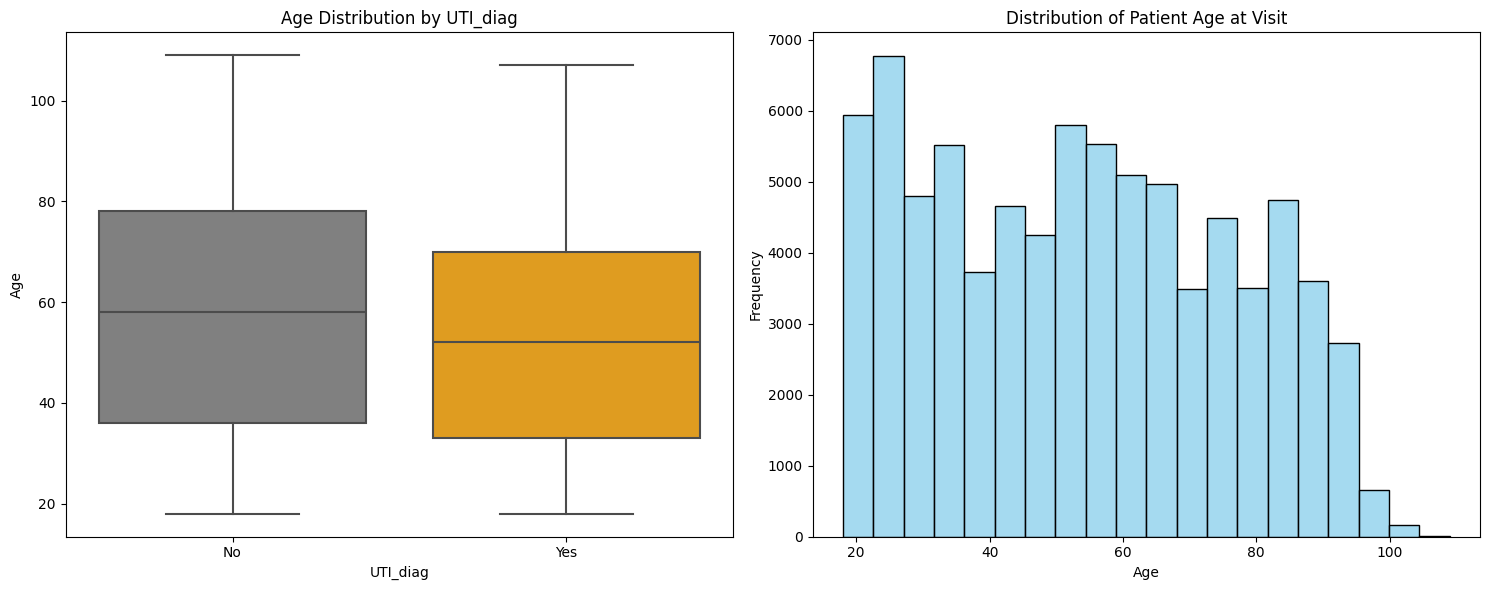

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a side-by-side box plot and a histogram in a single figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
sns.histplot(data=df, x='age', bins=20, color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Patient Age at Visit')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

# Box plot
sns.boxplot(data=df, x="UTI_diag", y="age", palette=["grey", "orange"], ax=axes[0])
axes[0].set_title("Age Distribution by UTI_diag")
axes[0].set_xlabel("UTI_diag")
axes[0].set_ylabel("Age")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["No", "Yes"])

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
# Calculate mean age for the entire dataset
mean_age = df["age"].mean()
print(f"Mean Age for the Entire Dataset: {mean_age:.2f}")

# Calculate mean age for "No" UTI_diag
mean_age_no = df[df["UTI_diag"] == "No"]["age"].mean()
print(f"Mean Age for UTI_diag 'No': {mean_age_no:.2f}")

# Calculate mean age for "Yes" UTI_diag
mean_age_yes = df[df["UTI_diag"] == "Yes"]["age"].mean()
print(f"Mean Age for UTI_diag 'Yes': {mean_age_yes:.2f}")

Mean Age for the Entire Dataset: 53.80
Mean Age for UTI_diag 'No': 52.84
Mean Age for UTI_diag 'Yes': 57.36


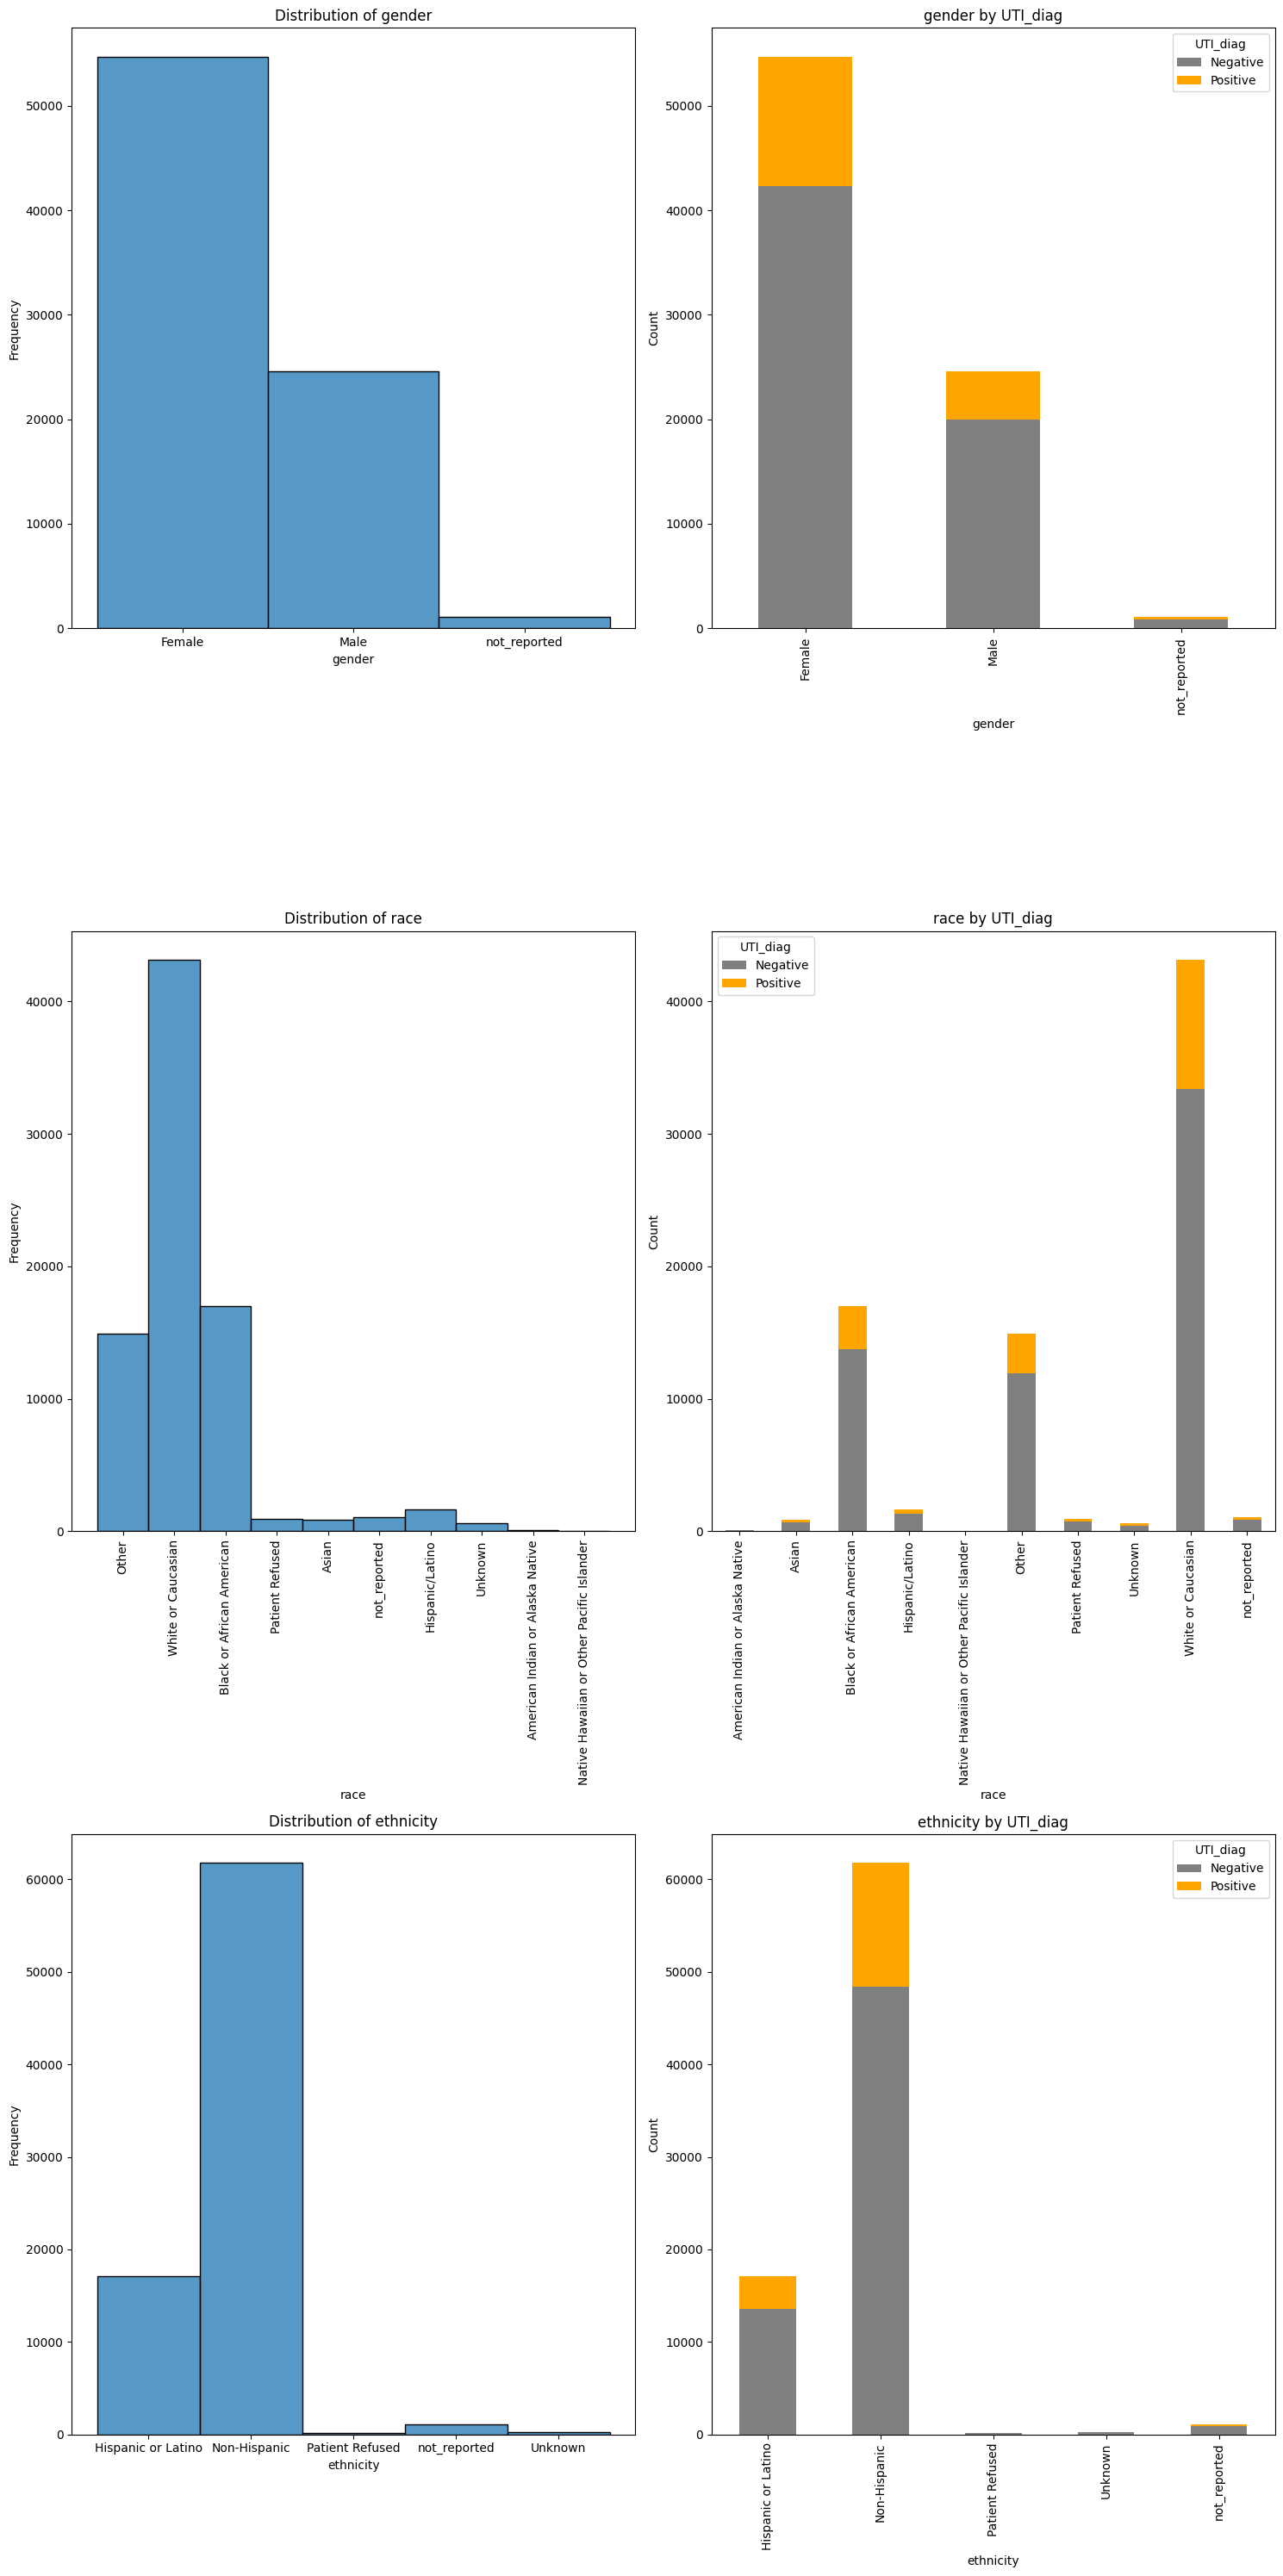

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of urinalysis variables to plot
ua_variables = ["gender", "race", "ethnicity"]
ua_categorical_variables = ["gender", "race", "ethnicity"]

# Create subplots with two columns
fig, axes = plt.subplots(nrows=len(ua_variables), ncols=2, figsize=(15, 30))

# Plot continuous variables on the left side
for i, variable in enumerate(ua_variables):
    sns.histplot(data=df, x=variable, bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {variable}")
    axes[i, 0].set_xlabel(variable)
    axes[i, 0].set_ylabel("Frequency")

    # Rotate x-axis labels for the "race" variable to match the right side
    if variable == "race":
        axes[i, 0].tick_params(axis='x', rotation=90)  # Adjust rotation angle as needed

# Plot categorical variables with respect to "UTI_diag" on the right side
for i, ua_variable in enumerate(ua_categorical_variables):
    cross_tab = pd.crosstab(df[ua_variable], df["UTI_diag"])
    cross_tab.plot(kind="bar", stacked=True, ax=axes[i, 1], color=["grey", "orange"])
    axes[i, 1].set_title(f"{ua_variable} by UTI_diag")
    axes[i, 1].set_xlabel(ua_variable)
    axes[i, 1].set_ylabel("Count")
    axes[i, 1].legend(title="UTI_diag", labels=["Negative", "Positive"])

# Adjust layout to increase vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.tight_layout()
plt.show()

In [17]:
# Calculate the proportion of "Yes" and "No" UTI_diag cases for each categorical variable
gender_proportions = df.groupby(["gender", "UTI_diag"])["UTI_diag"].count().unstack().fillna(0)
race_proportions = df.groupby(["race", "UTI_diag"])["UTI_diag"].count().unstack().fillna(0)
ethnicity_proportions = df.groupby(["ethnicity", "UTI_diag"])["UTI_diag"].count().unstack().fillna(0)

# Calculate the total count of cases for each categorical variable
total_counts_gender = gender_proportions.sum(axis=1)
total_counts_race = race_proportions.sum(axis=1)
total_counts_ethnicity = ethnicity_proportions.sum(axis=1)

# Calculate the proportion of "Yes" UTI_diag cases for each categorical variable
proportion_yes_gender = (gender_proportions["Yes"] / total_counts_gender).fillna(0)
proportion_yes_race = (race_proportions["Yes"] / total_counts_race).fillna(0)
proportion_yes_ethnicity = (ethnicity_proportions["Yes"] / total_counts_ethnicity).fillna(0)

# Display the results
print("Proportion of 'Yes' UTI_diag by Gender:")
print(proportion_yes_gender)

print("\nProportion of 'Yes' UTI_diag by Race:")
print(proportion_yes_race)

print("\nProportion of 'Yes' UTI_diag by Ethnicity:")
print(proportion_yes_ethnicity)


Proportion of 'Yes' UTI_diag by Gender:
gender
Female          0.226478
Male            0.185934
not_reported    0.186456
dtype: float64

Proportion of 'Yes' UTI_diag by Race:
race
American Indian or Alaska Native             0.202128
Asian                                        0.212791
Black or African American                    0.193378
Hispanic/Latino                              0.191362
Native Hawaiian or Other Pacific Islander    0.177778
Other                                        0.201018
Patient Refused                              0.209928
Unknown                                      0.238501
White or Caucasian                           0.227176
not_reported                                 0.186284
dtype: float64

Proportion of 'Yes' UTI_diag by Ethnicity:
ethnicity
Hispanic or Latino    0.202707
Non-Hispanic          0.216915
Patient Refused       0.190141
Unknown               0.245487
not_reported          0.186456
dtype: float64


In [18]:
from scipy.stats import chi2_contingency

categorical_vars = ['gender', 'race', 'ethnicity'] 

for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['UTI_diag'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"{var}: Chi-squared p-value = {p}")

gender: Chi-squared p-value = 8.105690857190588e-38
race: Chi-squared p-value = 1.2784590964301228e-20
ethnicity: Chi-squared p-value = 0.00012829401170904746


## Charts for Urinalysis Variables

In [19]:
from scipy.stats import chi2_contingency

categorical_vars = ["ua_bacteria", "ua_protein", "ua_ph", "ua_leuk", "ua_nitrite", "ua_glucose", "ua_bili", "ua_epi"
                    , "ua_blood", "ua_clarity", "ua_color"]  # Add your categorical variables here

for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['UTI_diag'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"{var}: Chi-squared p-value = {p}")

ua_bacteria: Chi-squared p-value = 0.0
ua_protein: Chi-squared p-value = 0.0
ua_ph: Chi-squared p-value = 8.315531530843427e-19
ua_leuk: Chi-squared p-value = 0.0
ua_nitrite: Chi-squared p-value = 0.0
ua_glucose: Chi-squared p-value = 9.173572875309494e-06
ua_bili: Chi-squared p-value = 2.1476764284364937e-53
ua_epi: Chi-squared p-value = 1.2036402347025647e-297
ua_blood: Chi-squared p-value = 0.0
ua_clarity: Chi-squared p-value = 0.0
ua_color: Chi-squared p-value = 4.5288365614815295e-138


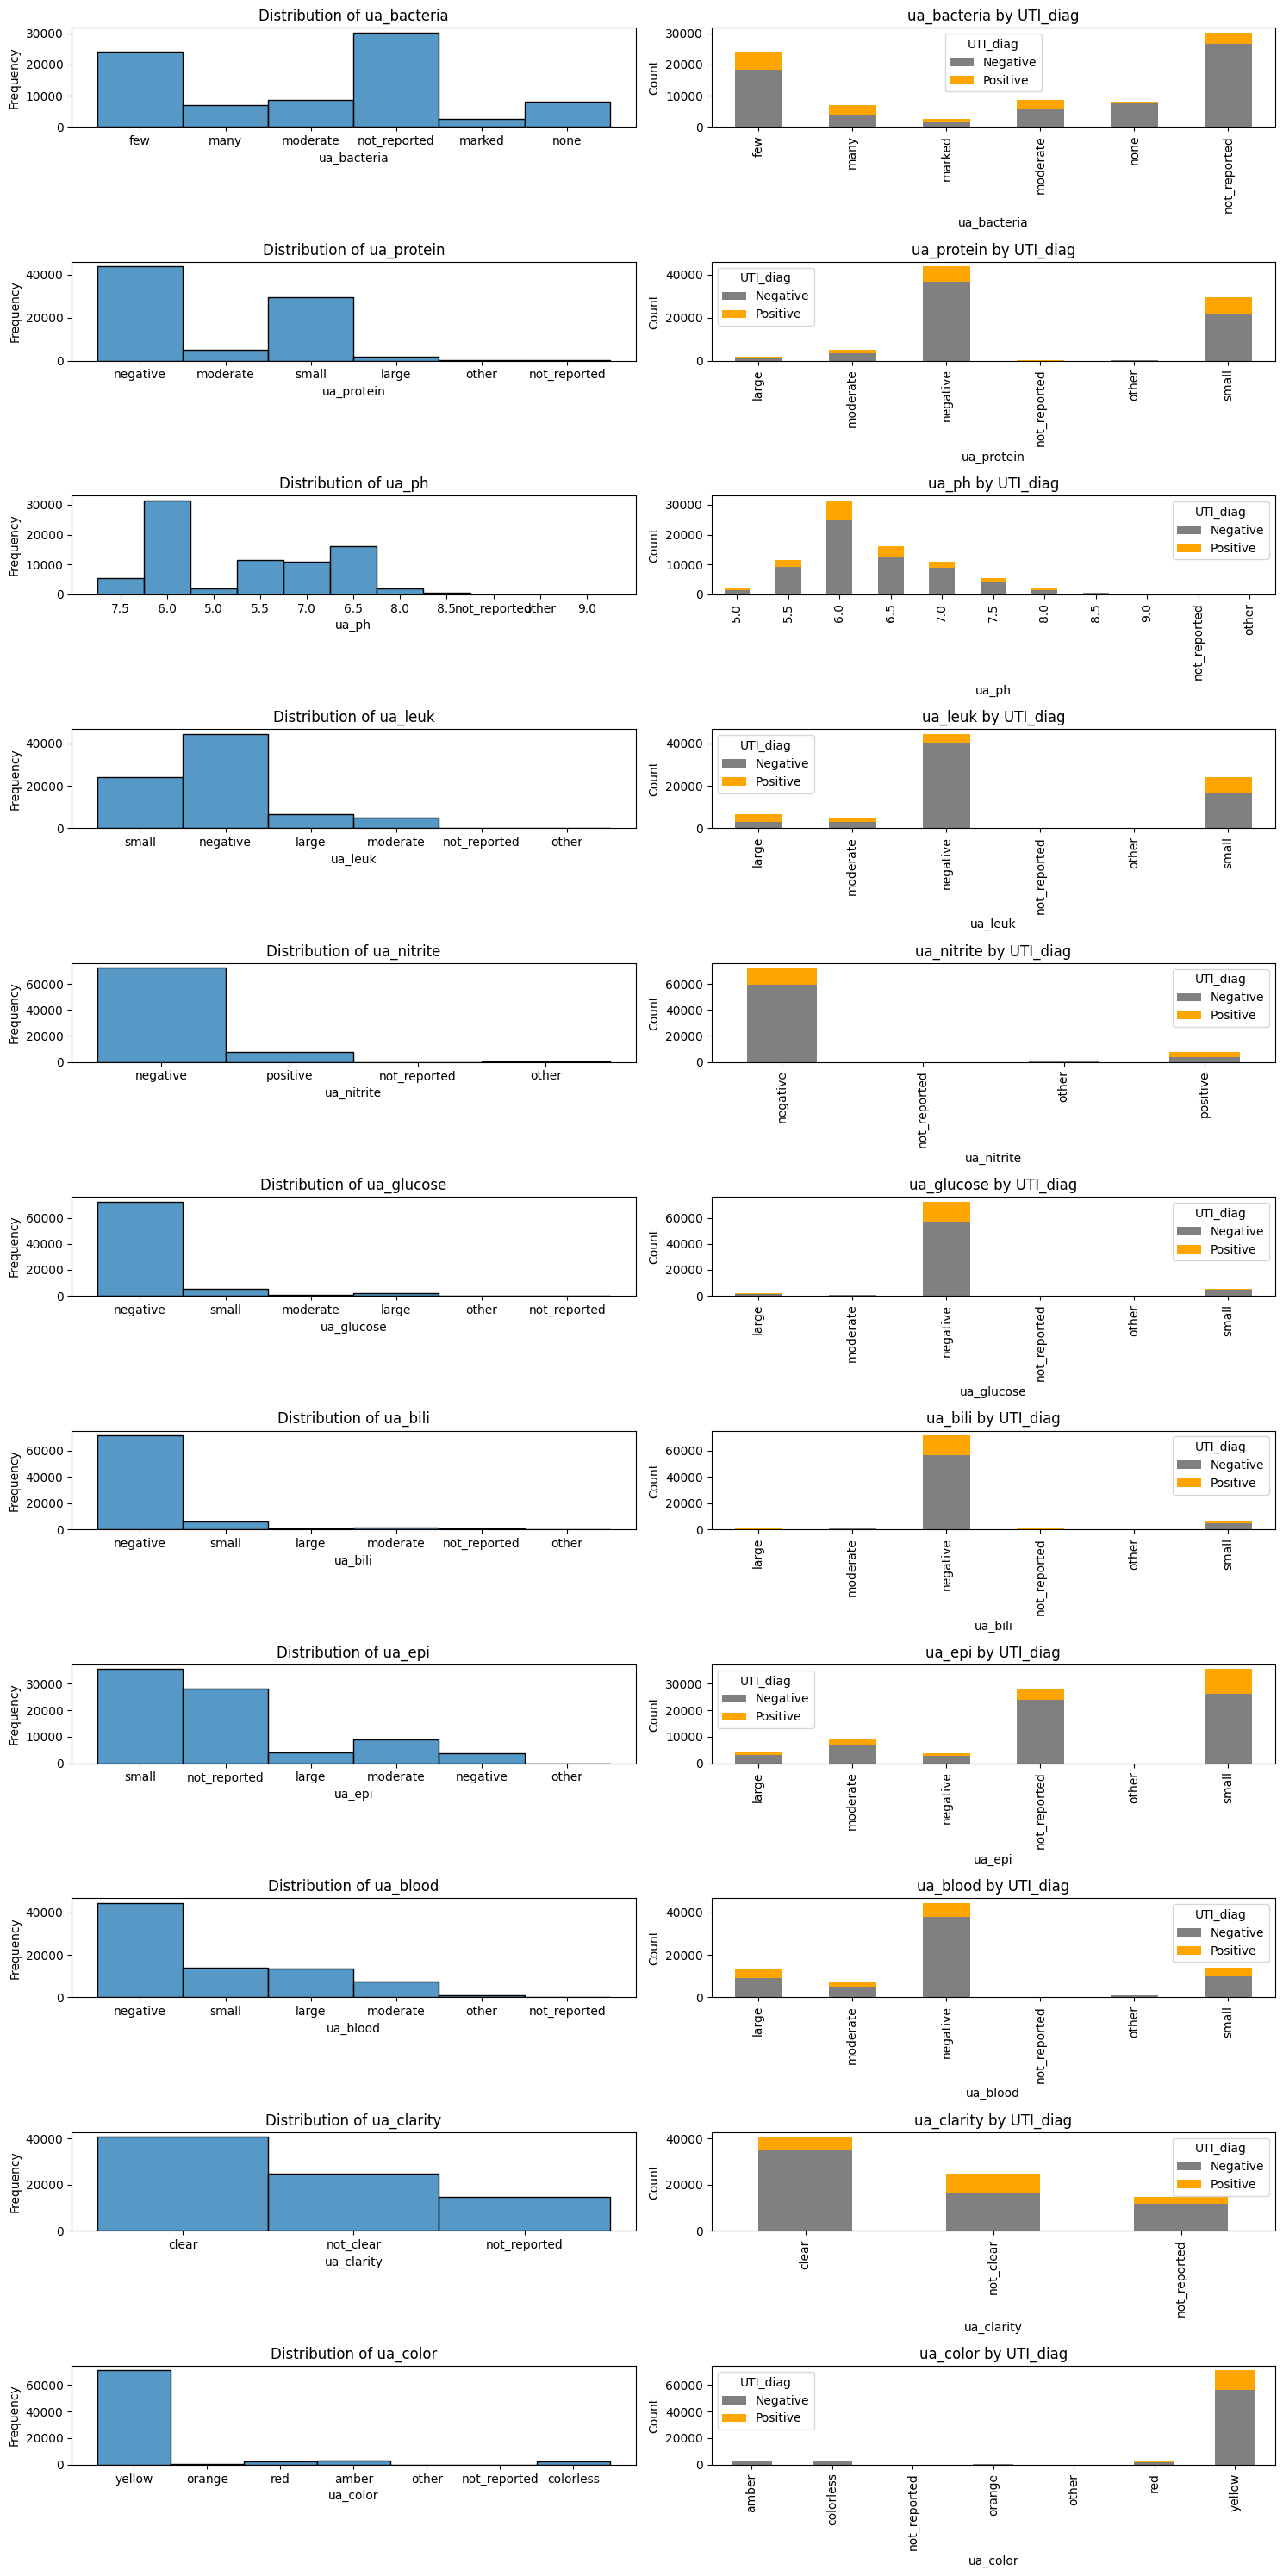

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of urinalysis variables to plot
ua_variables = ["ua_bacteria", "ua_protein", "ua_ph", "ua_leuk", "ua_nitrite", "ua_glucose", "ua_bili", "ua_epi", "ua_blood", "ua_clarity", "ua_color"]
ua_categorical_variables = ["ua_bacteria", "ua_protein", "ua_ph", "ua_leuk", "ua_nitrite", "ua_glucose", "ua_bili", "ua_epi", "ua_blood", "ua_clarity", "ua_color"]

# Create subplots with two columns
fig, axes = plt.subplots(nrows=len(ua_variables), ncols=2, figsize=(15, 30))

# Plot continuous variables on the left side
for i, variable in enumerate(ua_variables):
    sns.histplot(data=df, x=variable, bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {variable}")
    axes[i, 0].set_xlabel(variable)
    axes[i, 0].set_ylabel("Frequency")

# Plot categorical variables with respect to "UTI_diag" on the right side
for i, ua_variable in enumerate(ua_categorical_variables):
    cross_tab = pd.crosstab(df[ua_variable], df["UTI_diag"])
    cross_tab.plot(kind="bar", stacked=True, ax=axes[i, 1], color=["grey", "orange"])
    axes[i, 1].set_title(f"{ua_variable} by UTI_diag")
    axes[i, 1].set_xlabel(ua_variable)
    axes[i, 1].set_ylabel("Count")
    axes[i, 1].legend(title="UTI_diag", labels=["Negative", "Positive"])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Feature Selection and Preprocessing

In [25]:
filtered=(df.loc[:,['ua_bacteria', 'ua_blood', 'ua_leuk', 'ua_nitrite', 'age', 'gender', 'UTI_diag', 
                    'Urinary_tract_infections']]).dropna()
X=filtered.loc[:,['ua_bacteria', 'ua_blood', 'ua_leuk', 'age', 'ua_nitrite','gender','Urinary_tract_infections']]
y=filtered['UTI_diag']
X.head()

,ua_bacteria,ua_blood,ua_leuk,age,ua_nitrite,gender,Urinary_tract_infections
0,few,negative,small,83,negative,Female,No
1,many,small,negative,81,negative,Female,No
2,few,negative,small,78,negative,Female,No
3,many,negative,large,84,negative,Female,No
4,moderate,negative,small,55,positive,Male,No


In [26]:
# Define a mapping of ordinal values to their corresponding numerical labels

gend_map= {
    'Female': 0,
    'Male': 1,
    'not_reported': 0
}

bact_map = {
    'none': 0,
    'rare': 1,
    'few': 2,
    'moderate': 3,
    'many': 4,
    'marked': 5,
    'not_reported': 2.5
}
blood_map = {
    'negative': 0,
    'small': 1,
    'moderate': 2,
    'large': 3,
    'not_reported': 1.5,
    'other': 2.5
}

leuk_map= {
    'negative': 0,
    'small': 1,
    'moderate': 2,
    'large': 3,
    'not_reported': 1.5,
    'other': 2.5
}

diag_map= {
    'Yes': 1,
    'No': 0
}

uti_map = {
    'No': 0,
    'Yes': 1
}

nit_map = {
    'negative': 0,
    'positive': 1,
    'not_reported': 1.5,
    'other': 2.5
}

# Map values and add it to DataFrame X
X['gender']=X['gender'].map(gend_map)
X['ua_bacteria'] = X['ua_bacteria'].map(bact_map)
X['ua_blood'] = X['ua_blood'].map(blood_map)
X['ua_leuk'] = X['ua_leuk'].map(leuk_map)
X['ua_nitrite'] = X['ua_nitrite'].map(nit_map)
X['Urinary_tract_infections'] = X['Urinary_tract_infections'].map(uti_map)
y=y.map(diag_map)

for col in ['ua_bacteria', 'ua_blood', 'ua_leuk','ua_nitrite', 'gender', 'age', 'Urinary_tract_infections']:
    unique_values = X[col].unique()
    print(f'Unique values in {col}:')
    print(unique_values)

Unique values in ua_bacteria:
[2.  4.  3.  2.5 5.  0. ]
Unique values in ua_blood:
[0.  1.  3.  2.  2.5 1.5]
Unique values in ua_leuk:
[1.  0.  3.  2.  1.5 2.5]
Unique values in ua_nitrite:
[0.  1.  1.5 2.5]
Unique values in gender:
[0 1]
Unique values in age:
[ 83  81  78  84  55  47  64  89  31  54  82  67  24  36  46  72  52  93
  35 102  44  94  79  37  88 100  71  30  60  68  80  58  26  25  48  63
  75  49  29  90  65  40  73  42  27  22  96  50  51  59  85  66  98  86
  39  41  23  28  95  69  33  18  92  56  57  77  91  53  21  38  61  19
  62  20  87  45  97  70  34  32  43  76  74  99 105 104 103 101 106 109
 107]
Unique values in Urinary_tract_infections:
[0 1]


## Data Splitting

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(len(X_train))
print(len(X_val))
print(len(X_test))

64309
8039
8039


In [28]:
y_val

79632    0
50788    0
39283    0
6913     1
40656    0
        ..
67181    0
13249    0
79060    0
58324    1
64518    0
Name: UTI_diag, Length: 8039, dtype: int64

# Model Selection and Training

## Logistic Regression

In [29]:
log_mod=LogisticRegression(random_state=42)

log_mod.fit(X_train, y_train)

y_pred = log_mod.predict(X_val)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate and print balanced f1-score
balanced_f1 = f1_score(y_val, y_pred, average='weighted')
print(f'Balanced F1-score: {balanced_f1}')

# Calculate and print AUC
y_pred_prob = log_mod.predict_proba(X_val)[:, 1]  # Replace with predicted probabilities for the positive class
auc_roc = roc_auc_score(y_val, y_pred_prob)
print(f'AUC: {auc_roc}')

# Generate and print a classification report
classification_rep = classification_report(y_val, y_pred)
print('Classification Report:\n', classification_rep)

# Generate and print a confusion matrix
confusion = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:\n', confusion)

Accuracy: 0.80
Balanced F1-score: 0.771381523672614
AUC: 0.7777468180887953
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      6413
           1       0.53      0.23      0.32      1626

    accuracy                           0.80      8039
   macro avg       0.68      0.59      0.60      8039
weighted avg       0.77      0.80      0.77      8039

Confusion Matrix:
 [[6080  333]
 [1248  378]]


## Random Forest

In [30]:
for_mod=RandomForestClassifier(random_state=42)

for_mod.fit(X_train, y_train)

y_pred = for_mod.predict(X_val)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate and print balanced f1-score
balanced_f1 = f1_score(y_val, y_pred, average='weighted')
print(f'Balanced F1-score: {balanced_f1}')

# Calculate and print AUC
y_pred_prob = for_mod.predict_proba(X_val)[:, 1]  # Replace with predicted probabilities for the positive class
auc_roc = roc_auc_score(y_val, y_pred_prob)
print(f'AUC: {auc_roc}')

# Generate and print a classification report
classification_rep = classification_report(y_val, y_pred)
print('Classification Report:\n', classification_rep)

# Generate and print a confusion matrix
confusion = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:\n', confusion)

Accuracy: 0.79
Balanced F1-score: 0.7800021238695727
AUC: 0.734727842756363
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      6413
           1       0.49      0.34      0.40      1626

    accuracy                           0.79      8039
   macro avg       0.67      0.62      0.64      8039
weighted avg       0.77      0.79      0.78      8039

Confusion Matrix:
 [[5842  571]
 [1077  549]]


## xgboost

In [34]:
xg_mod=xgb.XGBClassifier(random_state=42)

xg_mod.fit(X_train, y_train)

y_pred = xg_mod.predict(X_val)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate and print balanced f1-score
balanced_f1 = f1_score(y_val, y_pred, average='weighted')
print(f'Balanced F1-score: {balanced_f1}')

# Calculate and print AUC
y_pred_prob = xg_mod.predict_proba(X_val)[:, 1]  # Replace with predicted probabilities for the positive class
auc_roc = roc_auc_score(y_val, y_pred_prob)
print(f'AUC: {auc_roc}')

# Generate and print a classification report
classification_rep = classification_report(y_val, y_pred)
print('Classification Report:\n', classification_rep)

# Generate and print a confusion matrix
confusion = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:\n', confusion)

Accuracy: 0.81
Balanced F1-score: 0.7875738030339021
AUC: 0.7899303747442589
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89      6413
           1       0.55      0.31      0.40      1626

    accuracy                           0.81      8039
   macro avg       0.70      0.62      0.64      8039
weighted avg       0.78      0.81      0.79      8039

Confusion Matrix:
 [[5994  419]
 [1118  508]]


### All models together

In [36]:
from xgboost import XGBClassifier  # Import the XGBClassifier class

# Logistic Regression
log_mod = LogisticRegression(random_state=42)
log_mod.fit(X_train, y_train)
y_pred_log = log_mod.predict(X_val)

# Random Forest
for_mod = RandomForestClassifier(random_state=42)
for_mod.fit(X_train, y_train)
y_pred_for = for_mod.predict(X_val)

# XGBoost
xgb_mod = XGBClassifier(random_state=42)
xgb_mod.fit(X_train, y_train)
y_pred_xgb = xgb_mod.predict(X_val)

# Function for model evaluation
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_f1 = f1_score(y_true, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    
    print(f'Model: {model_name}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Balanced F1-score: {balanced_f1:.2f}')
    print(f'AUC-ROC: {auc_roc:.2f}')
    print('Classification Report:\n', classification_rep)
    print('Confusion Matrix:\n', confusion)

# Evaluate models
evaluate_model(y_val, y_pred_log, 'Logistic Regression')
evaluate_model(y_val, y_pred_for, 'Random Forest')
evaluate_model(y_val, y_pred_xgb, 'XGBoost')

Model: Logistic Regression
Accuracy: 0.80
Balanced F1-score: 0.77
AUC-ROC: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      6413
           1       0.53      0.23      0.32      1626

    accuracy                           0.80      8039
   macro avg       0.68      0.59      0.60      8039
weighted avg       0.77      0.80      0.77      8039

Confusion Matrix:
 [[6080  333]
 [1248  378]]
Model: Random Forest
Accuracy: 0.79
Balanced F1-score: 0.78
AUC-ROC: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      6413
           1       0.49      0.34      0.40      1626

    accuracy                           0.79      8039
   macro avg       0.67      0.62      0.64      8039
weighted avg       0.77      0.79      0.78      8039

Confusion Matrix:
 [[5842  571]
 [1077  549]]
Model: XGBoost
Accuracy: 0.81
Balanced F1-score: 0.7

## Model Evaluation

Logistic Regression - AUC-ROC on Validation Data: 0.78
Logistic Regression - PR-AUC on Validation Data: 0.45
Logistic Regression - AUC-ROC on Testing Data: 0.77
Logistic Regression - PR-AUC on Testing Data: 0.45
Random Forest - AUC-ROC on Validation Data: 0.73
Random Forest - PR-AUC on Validation Data: 0.42
Random Forest - AUC-ROC on Testing Data: 0.72
Random Forest - PR-AUC on Testing Data: 0.43
XGBoost - AUC-ROC on Validation Data: 0.79
XGBoost - PR-AUC on Validation Data: 0.47
XGBoost - AUC-ROC on Testing Data: 0.77
XGBoost - PR-AUC on Testing Data: 0.46


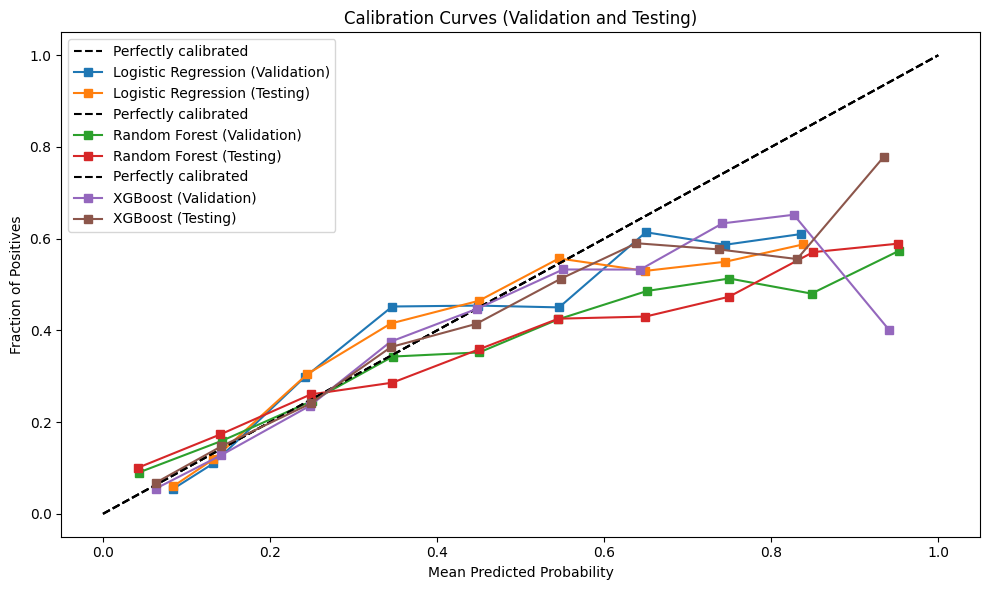

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.calibration import calibration_curve

# Function to plot calibration curves
def plot_calibration_curve(name, prob_pos, y_true, n_bins=10):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, prob_pos, n_bins=n_bins)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label=name)

# Initialize lists to store results
model_names = ["Logistic Regression", "Random Forest", "XGBoost"]
validation_auc_roc = []
validation_pr_auc = []
testing_auc_roc = []
testing_pr_auc = []

# Initialize subplots for separate calibration curve graphs
fig, axs = plt.subplots(figsize=(10, 6))

# Evaluate models on both validation and testing data
for i, (model_name, model) in enumerate([("Logistic Regression", log_mod), ("Random Forest", for_mod), ("XGBoost", xgb_mod)]):
    # Predict probabilities for validation data
    y_val_prob = model.predict_proba(X_val)[:, 1]

    # Calculate AUC-ROC and PR-AUC for validation data
    validation_auc_roc.append(roc_auc_score(y_val, y_val_prob))
    precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
    validation_pr_auc.append(auc(recall, precision))

    # Predict probabilities for testing data
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Calculate AUC-ROC and PR-AUC for testing data
    testing_auc_roc.append(roc_auc_score(y_test, y_test_prob))
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    testing_pr_auc.append(auc(recall, precision))

    # Plot Calibration Curves for both validation and testing data
    axs.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
    axs.set_xlabel('Mean Predicted Probability')
    axs.set_ylabel('Fraction of Positives')
    axs.set_title('Calibration Curves (Validation and Testing)')
    plot_calibration_curve(f'{model_name} (Validation)', y_val_prob, y_val, n_bins=10)
    plot_calibration_curve(f'{model_name} (Testing)', y_test_prob, y_test, n_bins=10)
    axs.legend(loc='best')

# Display AUC-ROC and PR-AUC results
for i, model_name in enumerate(model_names):
    print(f'{model_name} - AUC-ROC on Validation Data: {validation_auc_roc[i]:.2f}')
    print(f'{model_name} - PR-AUC on Validation Data: {validation_pr_auc[i]:.2f}')
    print(f'{model_name} - AUC-ROC on Testing Data: {testing_auc_roc[i]:.2f}')
    print(f'{model_name} - PR-AUC on Testing Data: {testing_pr_auc[i]:.2f}')

plt.tight_layout()
plt.show()  # Display combined calibration curve graph


### Extra

Logistic Regression Performance Metrics:
Accuracy: 0.80
Precision: 0.55
Recall: 0.24
F1-Score: 0.34
ROC AUC: 0.77
Random Forest Performance Metrics:
Accuracy: 0.79
Precision: 0.49
Recall: 0.34
F1-Score: 0.40
ROC AUC: 0.72
XGBoost Performance Metrics:
Accuracy: 0.80
Precision: 0.55
Recall: 0.31
F1-Score: 0.39
ROC AUC: 0.77


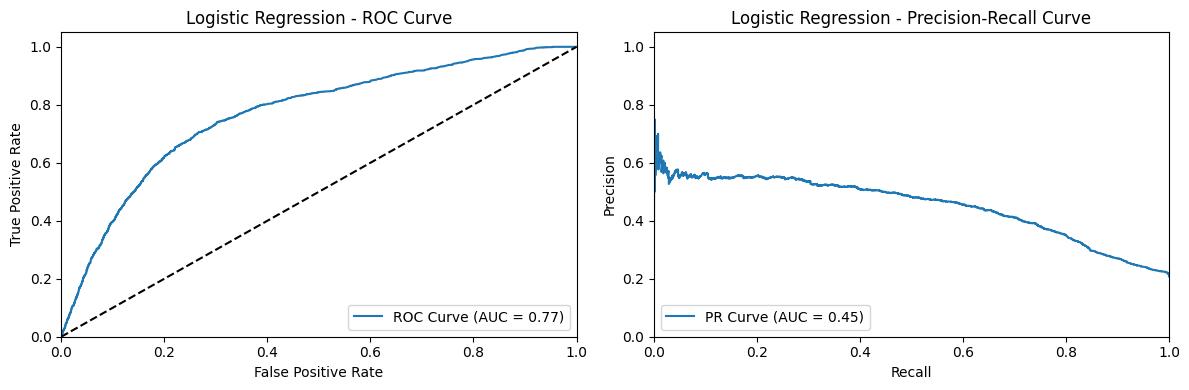

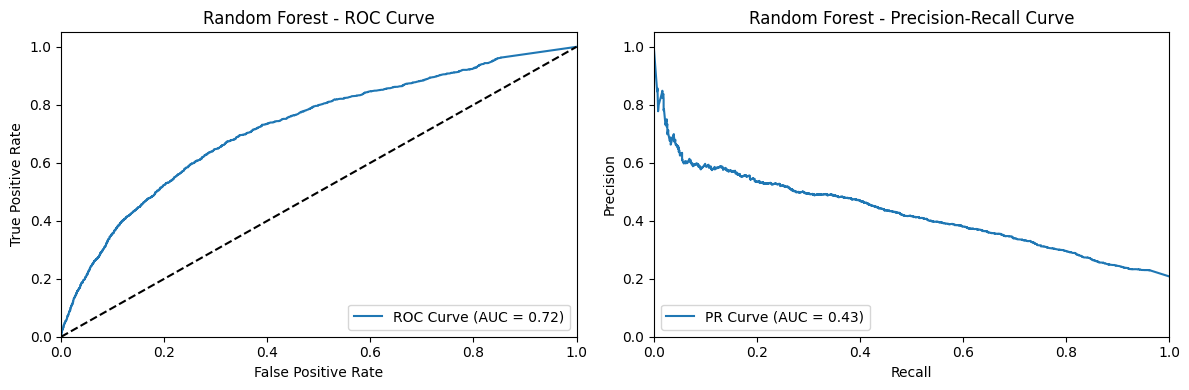

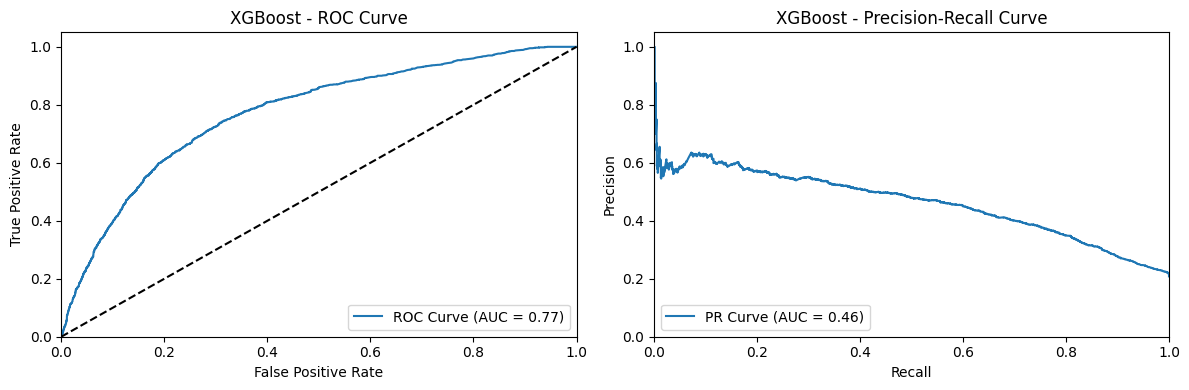

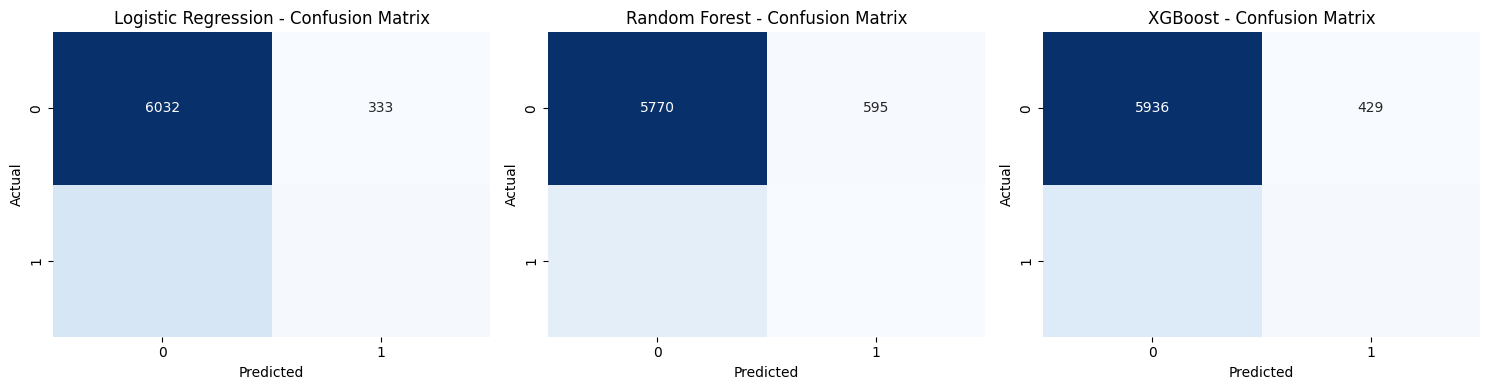

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

# Define a function to create ROC and PR curves and print performance metrics
def plot_curves(model, X, y, model_name):
    plt.figure(figsize=(12, 4))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    plt.tight_layout()

    # Print performance metrics
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)

    print(f'{model_name} Performance Metrics:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC and PR curves for Logistic Regression
plot_curves(log_mod, X_test, y_test, 'Logistic Regression')

# Plot ROC and PR curves for Random Forest
plot_curves(for_mod, X_test, y_test, 'Random Forest')

# Plot ROC and PR curves for XGBoost
plot_curves(xgb_mod, X_test, y_test, 'XGBoost')

# Show confusion matrix for each model
plt.figure(figsize=(15, 4))

# Confusion Matrix for Logistic Regression
plt.subplot(1, 3, 1)
logistic_preds = log_mod.predict(X_test)
sns.heatmap(confusion_matrix(y_test, logistic_preds), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix for Random Forest
plt.subplot(1, 3, 2)
rf_preds = for_mod.predict(X_test)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix for XGBoost
plt.subplot(1, 3, 3)
xgb_preds = xgb_mod.predict(X_test)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# Save the data

In [24]:
# Assuming 'df' is your original DataFrame
filtered_data = df.loc[:,['ua_bacteria', 'ua_blood', 'ua_leuk', 'ua_nitrite', 'age', 'gender', 'UTI_diag', 'Urinary_tract_infections']].dropna()

# Add an 'ID' column using the index
filtered_data['ID'] = range(1, len(filtered_data) + 1)

# Reorder columns with 'ID' as the first column
filtered_data = filtered_data[['ID', 'ua_bacteria', 'ua_blood', 'ua_leuk', 'ua_nitrite', 'age', 'gender', 'UTI_diag', 'Urinary_tract_infections']]

# Save the DataFrame to 'dat.csv'
filtered_data.to_csv('dat.csv', index=False)